In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, ReLU
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [4]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [5]:
ds_info.features["label"].num_classes

10

In [6]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

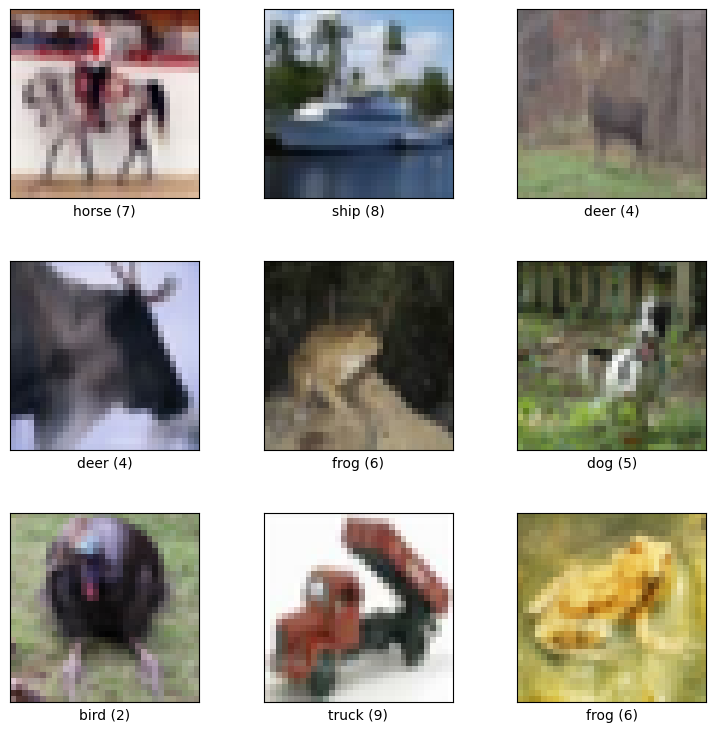

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

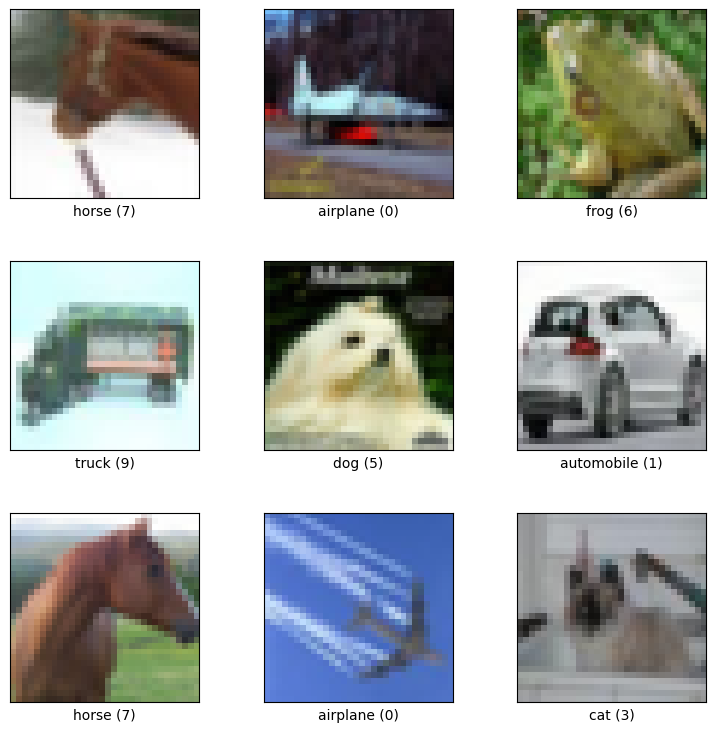

In [8]:
fig = tfds.show_examples(ds_test, ds_info)

In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
BATCH_SIZE = 16

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## 1) ResNet 기본 블록 구성하기

In [12]:
def conv_block(input_layer,
                channel,
                kernel_size,
                strides=1,
                activation='relu',):

    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)

    x = keras.layers.BatchNormalization()(x)

    if activation:
        x = keras.layers.Activation(activation)(x)

    return x

In [13]:
def build_net_block(input_layer,
                    cnn_count=3,
                    channel=64,
                    block_num=0,
                    is_50=True,):

    x = input_layer

    if is_50:
        for i in range(cnn_count):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)

            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)

    else:
        for i in range(cnn_count):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)

            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)

    return x

## 2) ResNet-34, ResNet-50 Complete Model

In [14]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=True,
                activation='softmax'):

    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)

    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)

    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x,
                            cnn_count=cnn_count,
                            channel=channel,
                            block_num=block_num,
                            is_50=is_50,)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes,
                        activation=activation,
                        kernel_initializer='he_normal'
                        )(x)

    model = keras.Model(inputs=input_layer, outputs=x)

    return model

## cifar10 데이터셋을 (32, 32, 3) input_shape로 할 ResNet-34 모델 생성

In [15]:
Resnet_34 = build_net(input_shape=(32, 32,3), is_50=False)
Resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

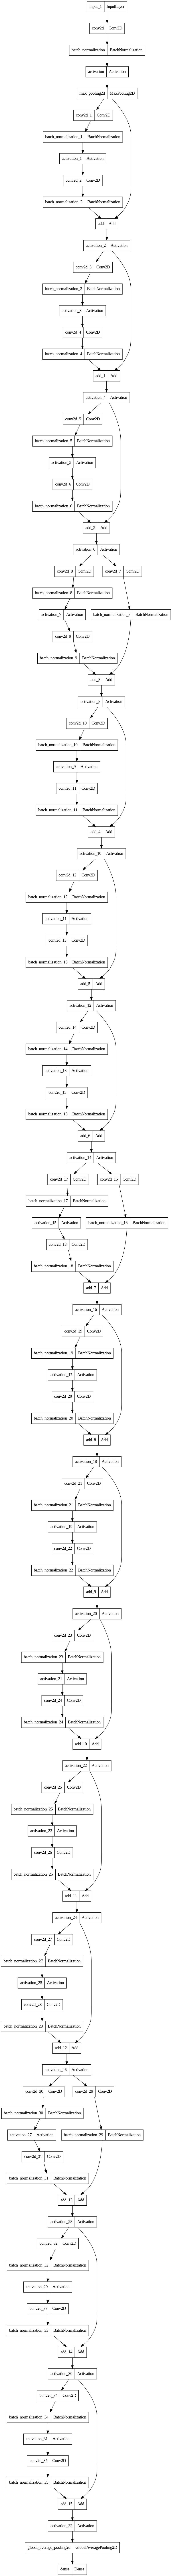

In [16]:
tf.keras.utils.plot_model(Resnet_34)

## cifar10 데이터셋을 (32, 32, 3) input_shape로 할 ResNet-50 모델 생성

In [17]:
Resnet_50 = build_net(input_shape=(32, 32,3), is_50=True)
Resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 16, 16, 64)           9408      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 16, 16, 64)           256       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_33 (Activation)  (None, 16, 16, 64)           0         ['batch_normalization_36

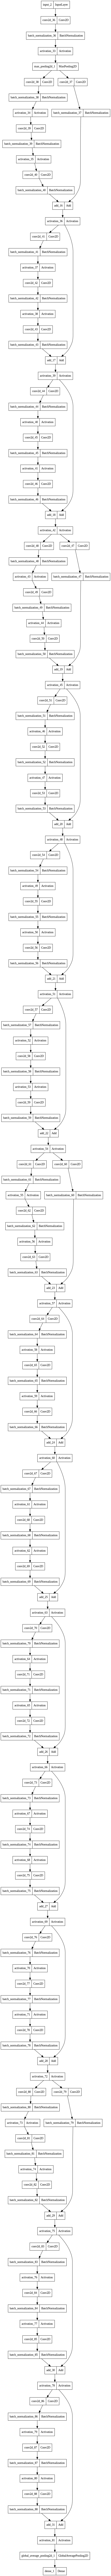

In [18]:
tf.keras.utils.plot_model(Resnet_50)

## 3) 일반 네트워크(plain network) 만들기

In [19]:
def build_plain_block(input_layer,
                      cnn_count=3,
                      channel=64,
                      block_num=0,
                      is_50=True,):

    x = input_layer

    if is_50:
        for i in range(cnn_count):
            if i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))

            x = keras.layers.Activation('relu')(x)

    else:
        for i in range(cnn_count):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

            x = keras.layers.Activation('relu')(x)

    return x

In [20]:
def build_plainnet(input_shape=(32,32,3),
                    cnn_count_list=[3,4,6,3],
                    channel_list=[64,128,256,512],
                    num_classes=10,
                    is_50=True,
                    activation='softmax'):

    assert len(cnn_count_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)

    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_plain_block(x,
                              cnn_count=cnn_count,
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50,)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes,
                           activation=activation,
                           kernel_initializer='he_normal'
                           )(x)

    model = keras.Model(inputs=input_layer, outputs=x)

    return model

## cifar10 데이터셋을 (224, 224, 3) input_shape로 할 Plain-34 일반 네트워크 모델 생성

In [21]:
PlainNet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False)
PlainNet_34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        3686

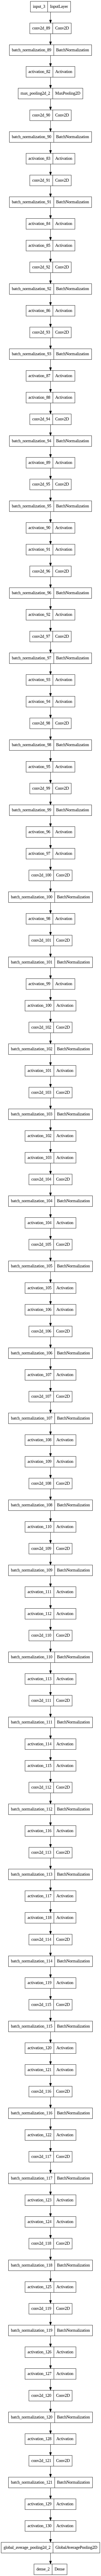

In [22]:
tf.keras.utils.plot_model(PlainNet_34)

## cifar10 데이터셋을 (224, 224, 3) input_shape로 할 Plain-50 일반 네트워크 모델 생성

In [23]:
PlainNet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)
PlainNet_50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_131 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                           

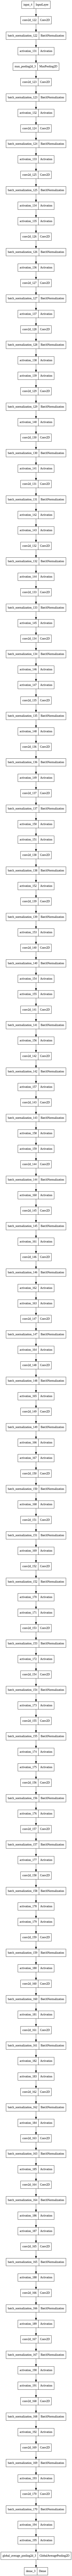

In [24]:
tf.keras.utils.plot_model(PlainNet_50)

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [25]:
(cat_dog_ds_train, cat_dog_ds_test), ds_cat_dog_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [26]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(cat_dog_ds_train))
print(tf.data.experimental.cardinality(cat_dog_ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [27]:
ds_cat_dog_info.features["label"].num_classes

2

In [28]:
ds_cat_dog_info.features["label"].names

['cat', 'dog']

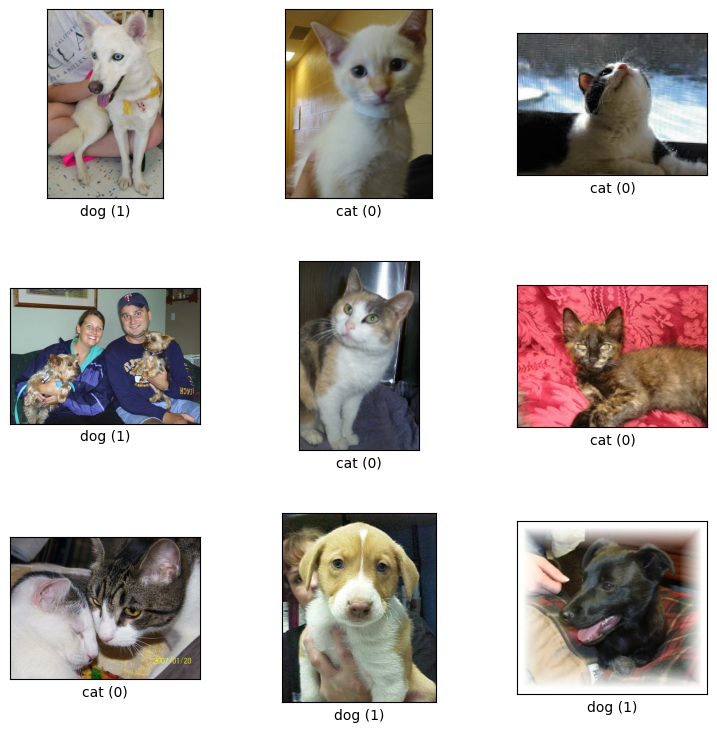

In [29]:
fig = tfds.show_examples(cat_dog_ds_train, ds_cat_dog_info)

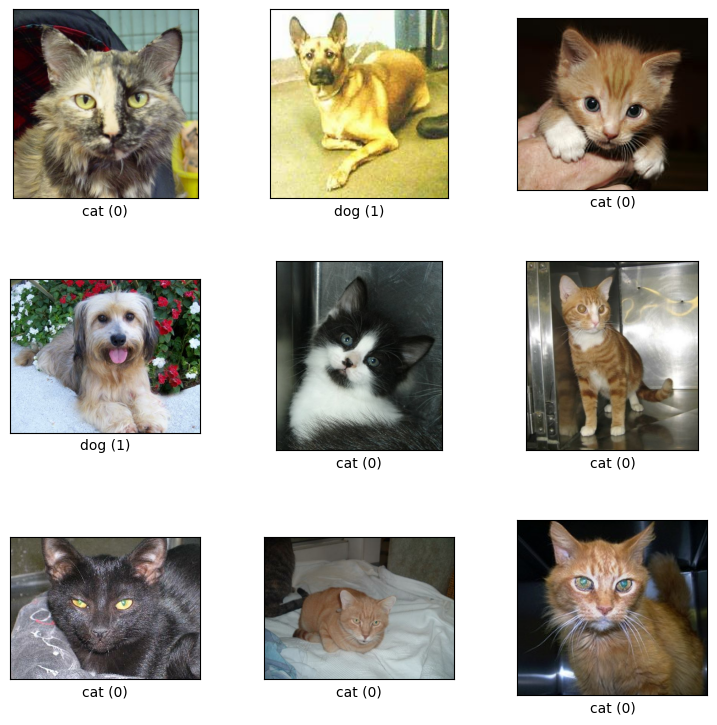

In [30]:
fig = tfds.show_examples(cat_dog_ds_test, ds_cat_dog_info)

In [31]:
cat_dog_ds_train = apply_normalize_on_dataset(cat_dog_ds_train, batch_size=BATCH_SIZE)
cat_dog_ds_test = apply_normalize_on_dataset(cat_dog_ds_test, batch_size=BATCH_SIZE)

## cats_vs_dogs 데이터셋을 (224, 224, 3) input_shape로 할 ResNet-34 모델 생성

In [32]:
cat_dog_resnet_34 = build_net(input_shape=(224,224, 3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=1,
                is_50=False,
                activation='sigmoid')
cat_dog_resnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 112, 112, 64)         9408      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_171 (B  (None, 112, 112, 64)         256       ['conv2d_171[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_196 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_17

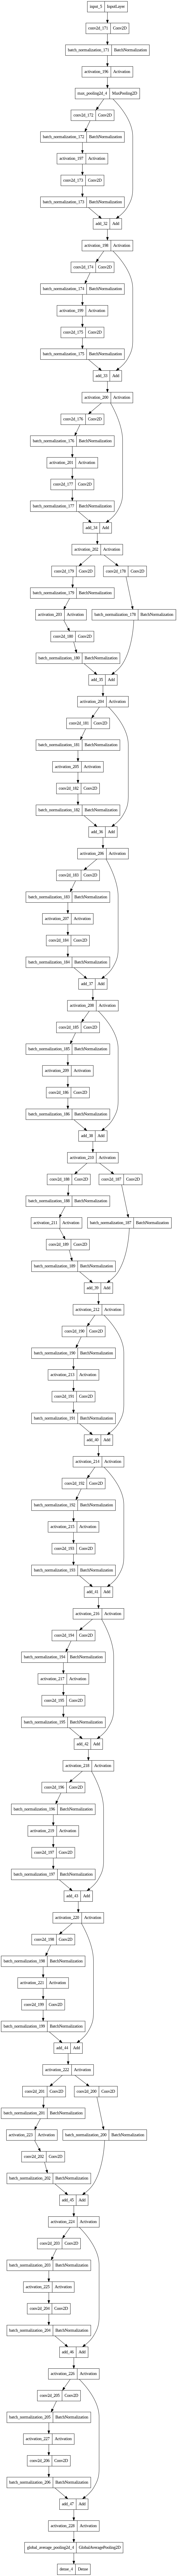

In [33]:
tf.keras.utils.plot_model(cat_dog_resnet_34)

## cats_vs_dogs 데이터셋을 (224, 224, 3) input_shape로 할 ResNet-50 모델 생성

In [34]:
cat_dog_resnet_50 = build_net(input_shape=(224,224, 3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=1,
                is_50=True,
                activation='sigmoid')
cat_dog_resnet_50.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_207 (Conv2D)         (None, 112, 112, 64)         9408      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_207 (B  (None, 112, 112, 64)         256       ['conv2d_207[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_229 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_20

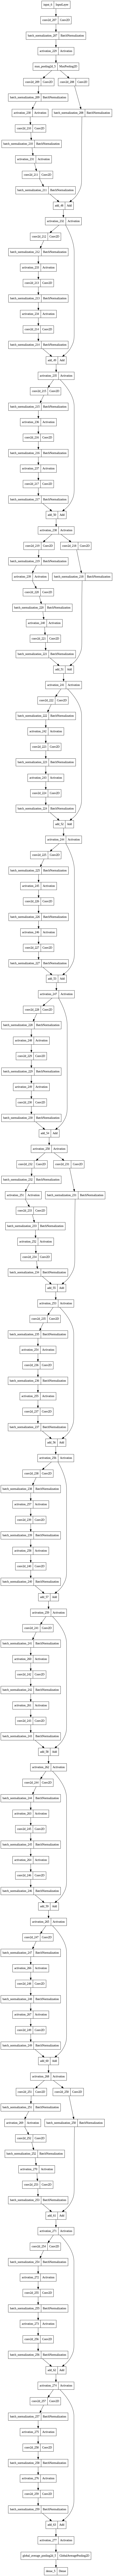

In [35]:
tf.keras.utils.plot_model(cat_dog_resnet_50)

## cats_vs_dogs 데이터셋을 (224, 224, 3) input_shape로 할 Plain-34 일반 네트워크 모델 생성

In [36]:
cat_dog_plain_34 = build_plainnet(input_shape=(224,224, 3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=1,
                is_50=False,
                activation='sigmoid')
cat_dog_plain_34.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_260 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_260 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_278 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                           

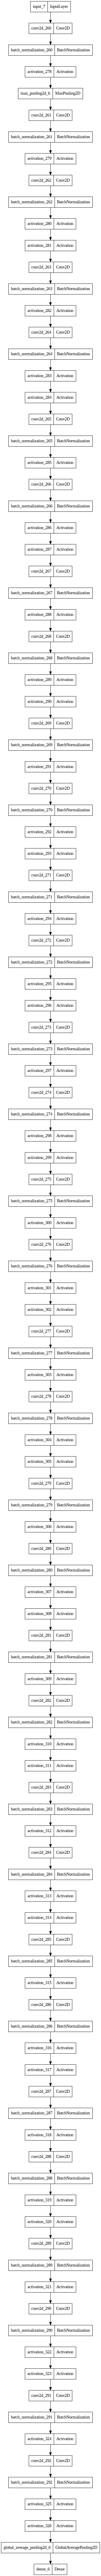

In [37]:
tf.keras.utils.plot_model(cat_dog_plain_34)

## cats_vs_dogs 데이터셋을 (224, 224, 3) input_shape로 할 Plain-50 일반 네트워크 모델 생성

In [38]:
cat_dog_plain_50 = build_plainnet(input_shape=(224,224, 3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=1,
                is_50=True,
                activation='sigmoid')
cat_dog_plain_50.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_293 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_293 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_327 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                           

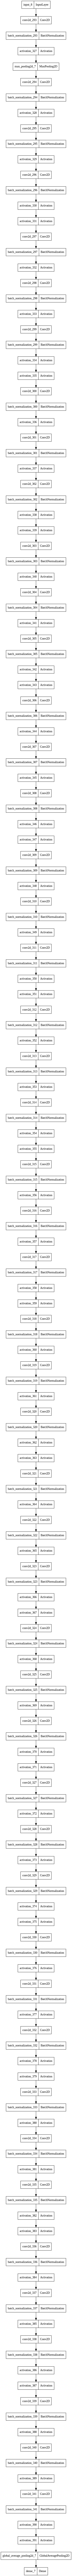

In [39]:
tf.keras.utils.plot_model(cat_dog_plain_50)

In [40]:
def train_model(model, ds_train, ds_test, ds_info, BATCH_SIZE, EPOCH):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, clipnorm=1.),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

In [41]:
history_Resnet_34 = train_model(cat_dog_resnet_34, cat_dog_ds_train, cat_dog_ds_test, ds_cat_dog_info, 32, 10)

Epoch 1/10
581/581 [==============================] - 100s 123ms/step - loss: 0.6829 - accuracy: 0.5744 - val_loss: 0.6603 - val_accuracy: 0.6052
Epoch 2/10
581/581 [==============================] - 72s 125ms/step - loss: 0.6509 - accuracy: 0.6223 - val_loss: 0.6755 - val_accuracy: 0.5888
Epoch 3/10
581/581 [==============================] - 70s 121ms/step - loss: 0.6351 - accuracy: 0.6358 - val_loss: 0.6491 - val_accuracy: 0.6198
Epoch 4/10
581/581 [==============================] - 72s 123ms/step - loss: 0.6247 - accuracy: 0.6425 - val_loss: 0.6377 - val_accuracy: 0.6319
Epoch 5/10
581/581 [==============================] - 72s 123ms/step - loss: 0.6097 - accuracy: 0.6616 - val_loss: 0.6334 - val_accuracy: 0.6481
Epoch 6/10
581/581 [==============================] - 70s 121ms/step - loss: 0.6037 - accuracy: 0.6725 - val_loss: 0.6315 - val_accuracy: 0.6315
Epoch 7/10
581/581 [==============================] - 72s 123ms/step - loss: 0.5892 - accuracy: 0.6826 - val_loss: 0.6236 - val_a

In [42]:
history_Resnet_50 = train_model(cat_dog_resnet_50, cat_dog_ds_train, cat_dog_ds_test, ds_cat_dog_info, 32, 10)

Epoch 1/10
581/581 [==============================] - 80s 99ms/step - loss: 0.6993 - accuracy: 0.5411 - val_loss: 0.6972 - val_accuracy: 0.5392
Epoch 2/10
581/581 [==============================] - 55s 95ms/step - loss: 0.6927 - accuracy: 0.5589 - val_loss: 0.7011 - val_accuracy: 0.5371
Epoch 3/10
581/581 [==============================] - 54s 93ms/step - loss: 0.6867 - accuracy: 0.5647 - val_loss: 0.6777 - val_accuracy: 0.5629
Epoch 4/10
581/581 [==============================] - 54s 93ms/step - loss: 0.6832 - accuracy: 0.5650 - val_loss: 0.6831 - val_accuracy: 0.5872
Epoch 5/10
581/581 [==============================] - 54s 94ms/step - loss: 0.6857 - accuracy: 0.5659 - val_loss: 0.7089 - val_accuracy: 0.5444
Epoch 6/10
581/581 [==============================] - 55s 95ms/step - loss: 0.6814 - accuracy: 0.5714 - val_loss: 0.6985 - val_accuracy: 0.5530
Epoch 7/10
581/581 [==============================] - 53s 92ms/step - loss: 0.6751 - accuracy: 0.5819 - val_loss: 0.6734 - val_accuracy:

In [43]:
history_Plain_34 = train_model(cat_dog_plain_34, cat_dog_ds_train, cat_dog_ds_test, ds_cat_dog_info, 32, 10)

Epoch 1/10
581/581 [==============================] - 95s 125ms/step - loss: 0.6935 - accuracy: 0.5470 - val_loss: 0.6878 - val_accuracy: 0.5423
Epoch 2/10
581/581 [==============================] - 71s 122ms/step - loss: 0.6828 - accuracy: 0.5659 - val_loss: 0.6846 - val_accuracy: 0.5621
Epoch 3/10
581/581 [==============================] - 83s 143ms/step - loss: 0.6818 - accuracy: 0.5624 - val_loss: 0.6877 - val_accuracy: 0.5776
Epoch 4/10
581/581 [==============================] - 74s 128ms/step - loss: 0.6812 - accuracy: 0.5716 - val_loss: 0.6801 - val_accuracy: 0.5629
Epoch 5/10
581/581 [==============================] - 76s 131ms/step - loss: 0.6800 - accuracy: 0.5749 - val_loss: 0.6756 - val_accuracy: 0.5841
Epoch 6/10
581/581 [==============================] - 70s 121ms/step - loss: 0.6792 - accuracy: 0.5687 - val_loss: 0.6804 - val_accuracy: 0.5629
Epoch 7/10
581/581 [==============================] - 75s 129ms/step - loss: 0.6765 - accuracy: 0.5768 - val_loss: 0.6789 - val_ac

In [44]:
history_Plain_50 = train_model(cat_dog_plain_50, cat_dog_ds_train, cat_dog_ds_test, ds_cat_dog_info, 32, 10)

Epoch 1/10
581/581 [==============================] - 102s 128ms/step - loss: 0.6915 - accuracy: 0.5363 - val_loss: 0.7130 - val_accuracy: 0.5116
Epoch 2/10
581/581 [==============================] - 62s 107ms/step - loss: 0.6877 - accuracy: 0.5558 - val_loss: 0.7126 - val_accuracy: 0.5229
Epoch 3/10
581/581 [==============================] - 53s 91ms/step - loss: 0.6884 - accuracy: 0.5527 - val_loss: 0.6933 - val_accuracy: 0.5445
Epoch 4/10
581/581 [==============================] - 53s 91ms/step - loss: 0.6865 - accuracy: 0.5492 - val_loss: 0.7064 - val_accuracy: 0.5263
Epoch 5/10
581/581 [==============================] - 50s 85ms/step - loss: 0.6866 - accuracy: 0.5528 - val_loss: 0.7134 - val_accuracy: 0.5418
Epoch 6/10
581/581 [==============================] - 53s 91ms/step - loss: 0.6864 - accuracy: 0.5608 - val_loss: 0.7234 - val_accuracy: 0.5199
Epoch 7/10
581/581 [==============================] - 52s 90ms/step - loss: 0.6866 - accuracy: 0.5565 - val_loss: 0.6942 - val_accura

## 시각화

In [69]:
def plot_training_metrics(histories, model_names, metric_names):
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 6 * num_metrics))

    epochs = range(1, len(histories[0].history[metric_names[0]]) + 1)

    for i, metric_name in enumerate(metric_names):
        for j, history in enumerate(histories):
            metric = history.history[metric_name]
            model_name = model_names[j]
            axes[i].plot(epochs, metric, label=f'{model_name} {metric_name}', marker='o', linestyle='-')

        axes[i].set_title(f'Training {metric_name} for {", ".join(model_names)}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric_name)
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

## ResNet-34, ResNet-50의 비교 결과 시각화

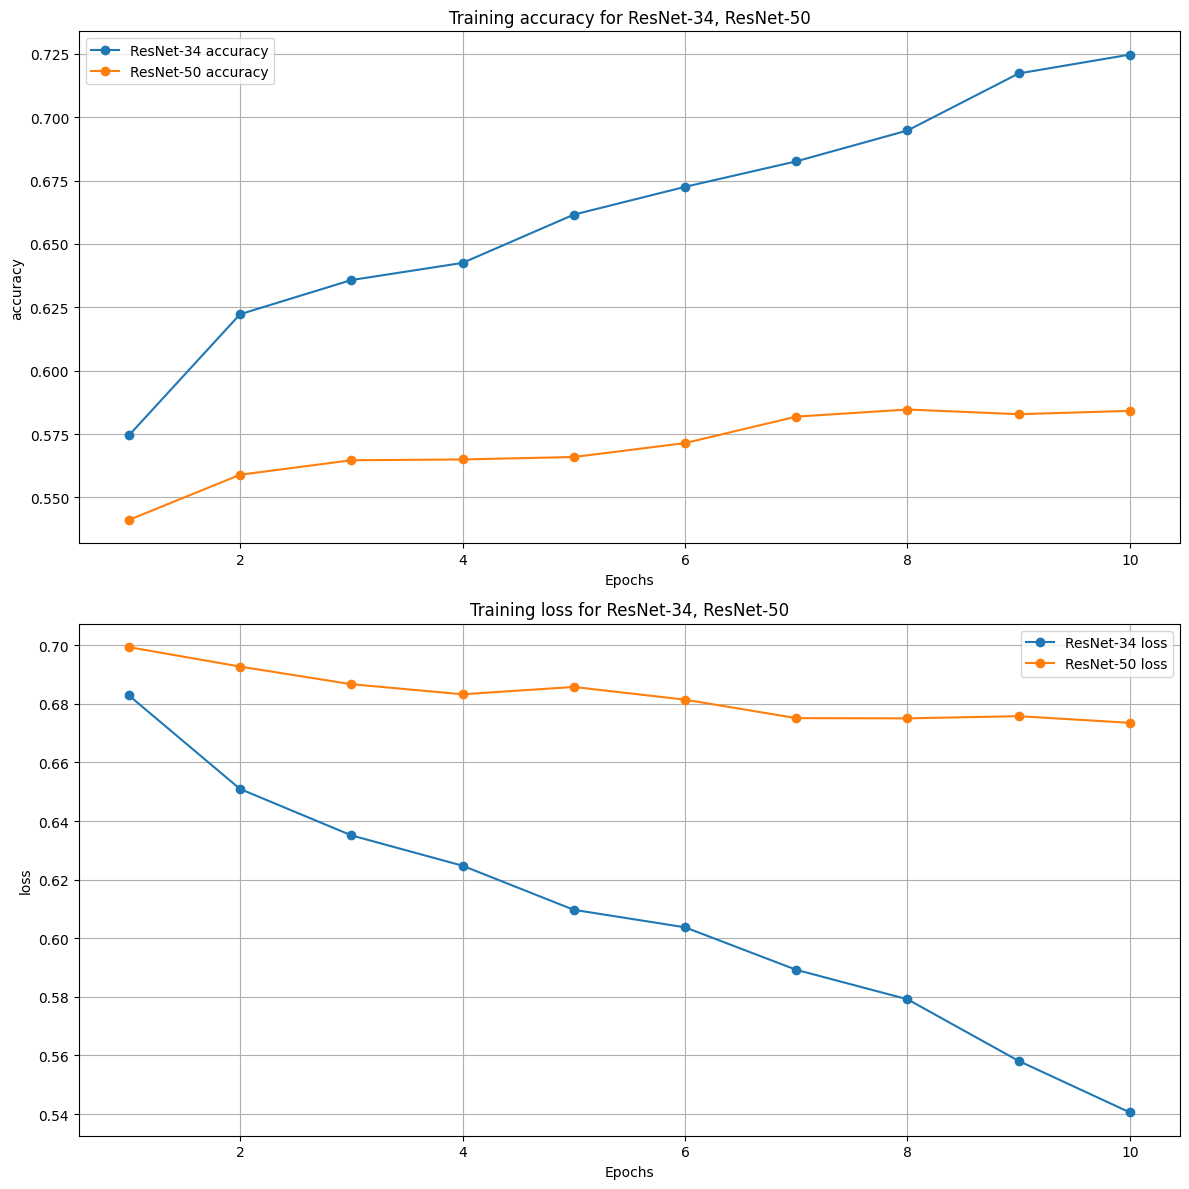

In [70]:
Resnet_hisotries = [history_Resnet_34, history_Resnet_50]
Resnet_model_name = ['ResNet-34', 'ResNet-50']

plot_training_metrics(Resnet_hisotries, Resnet_model_name, ['accuracy', 'loss'])

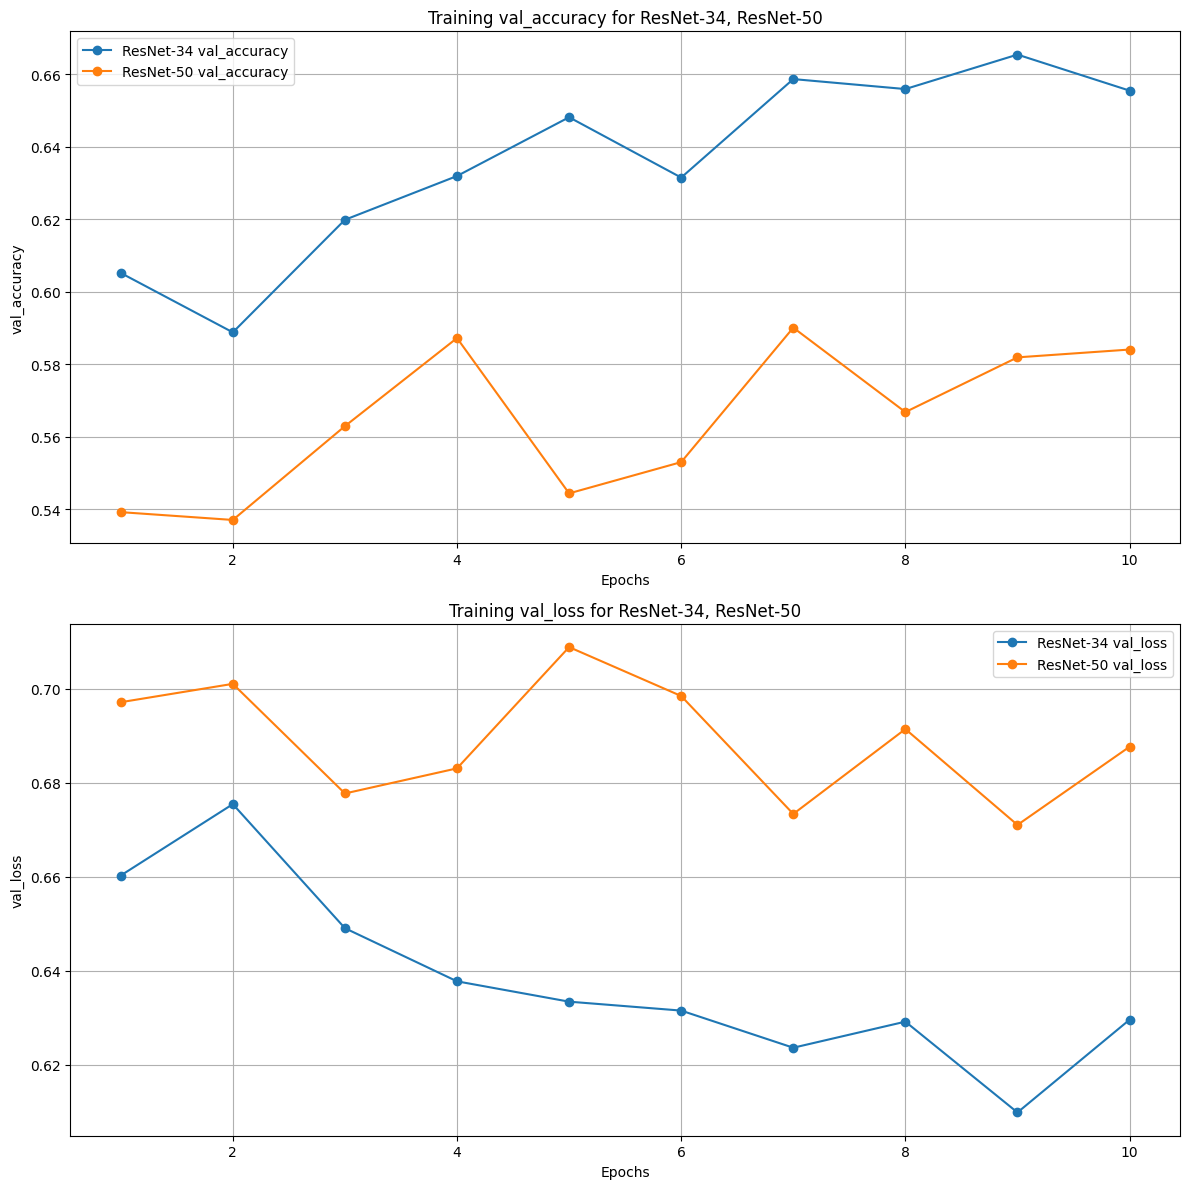

In [71]:
plot_training_metrics(Resnet_hisotries, Resnet_model_name, ['val_accuracy', 'val_loss'])

## Plain-34, Plain-50의 비교 결과 시각화

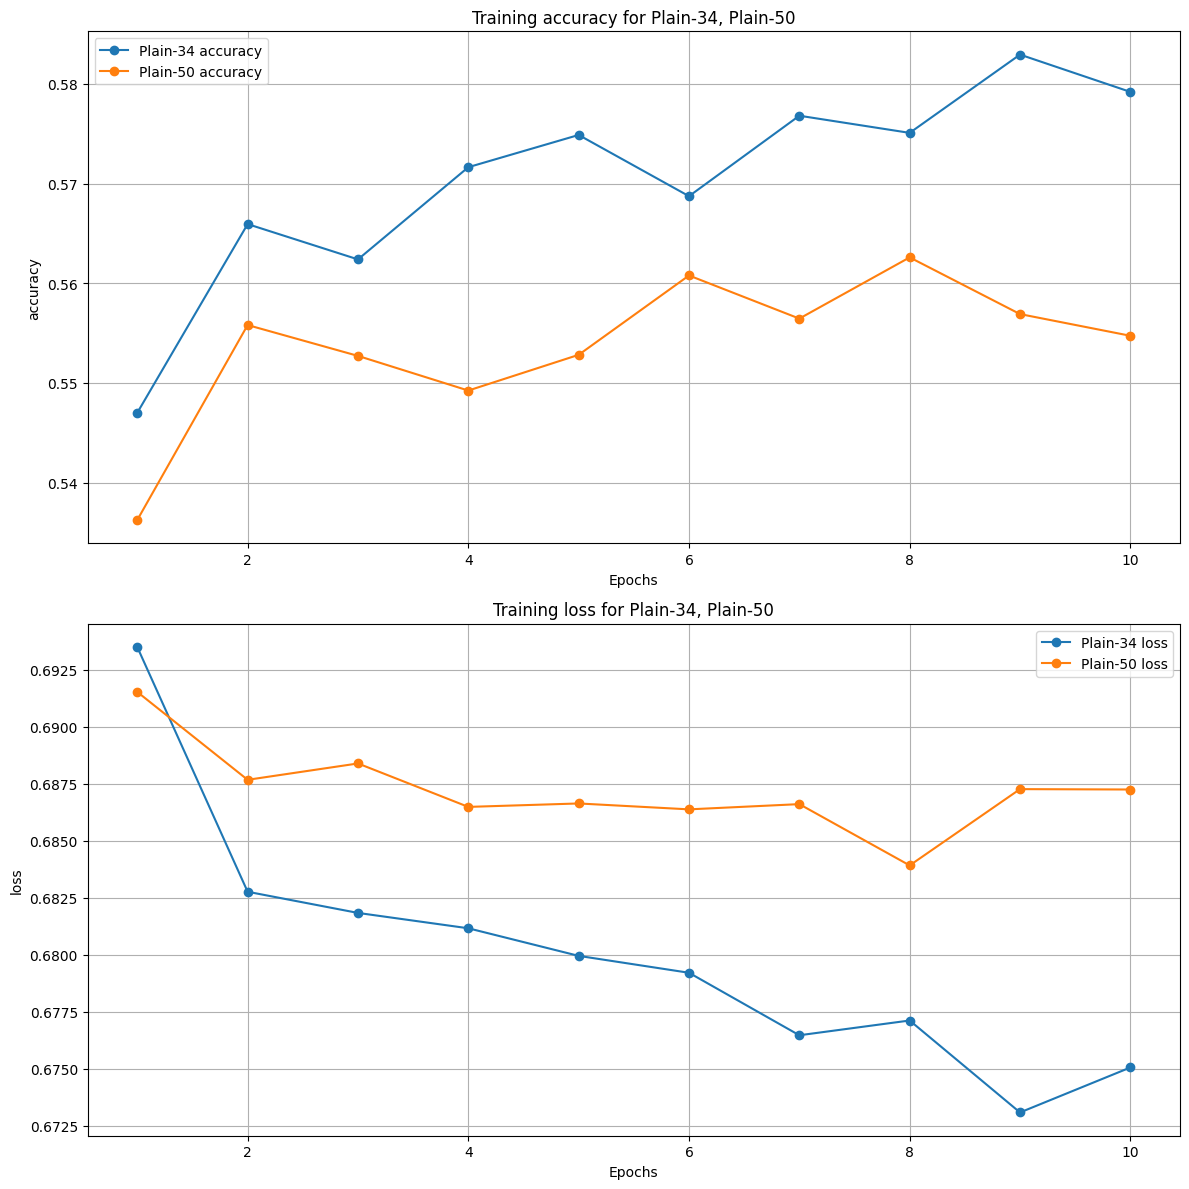

In [72]:
Plain_hisotries = [history_Plain_34, history_Plain_50]
Plain_model_name = ['Plain-34', 'Plain-50']

plot_training_metrics(Plain_hisotries, Plain_model_name, ['accuracy', 'loss'])

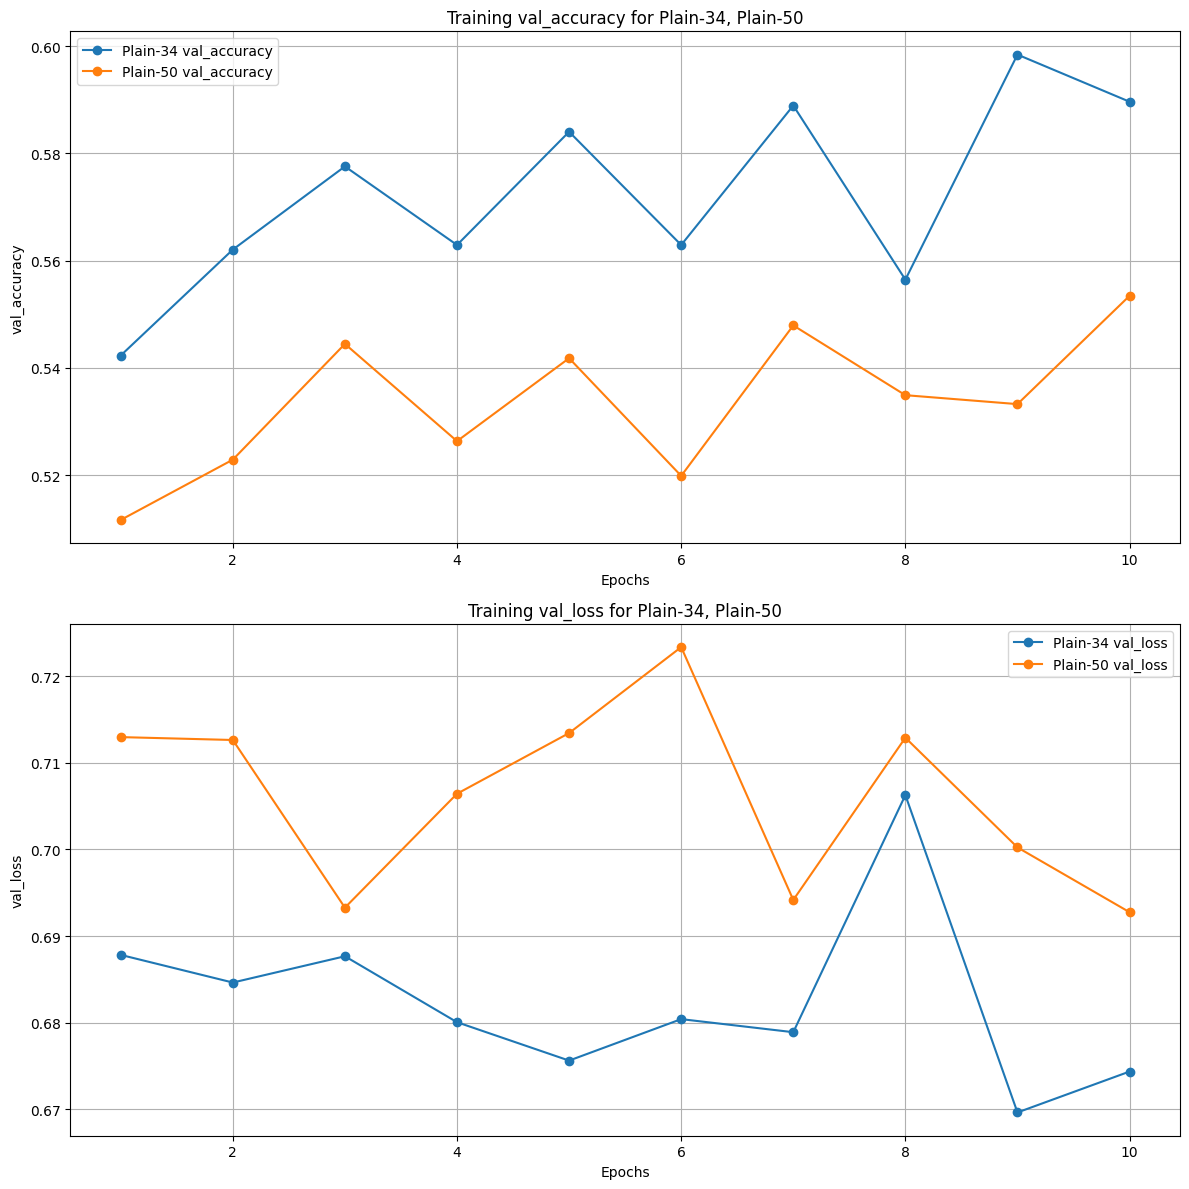

In [73]:
plot_training_metrics(Plain_hisotries, Plain_model_name, ['val_accuracy', 'val_loss'])

## ResNet-34, Plain-34의 비교 결과 시각화

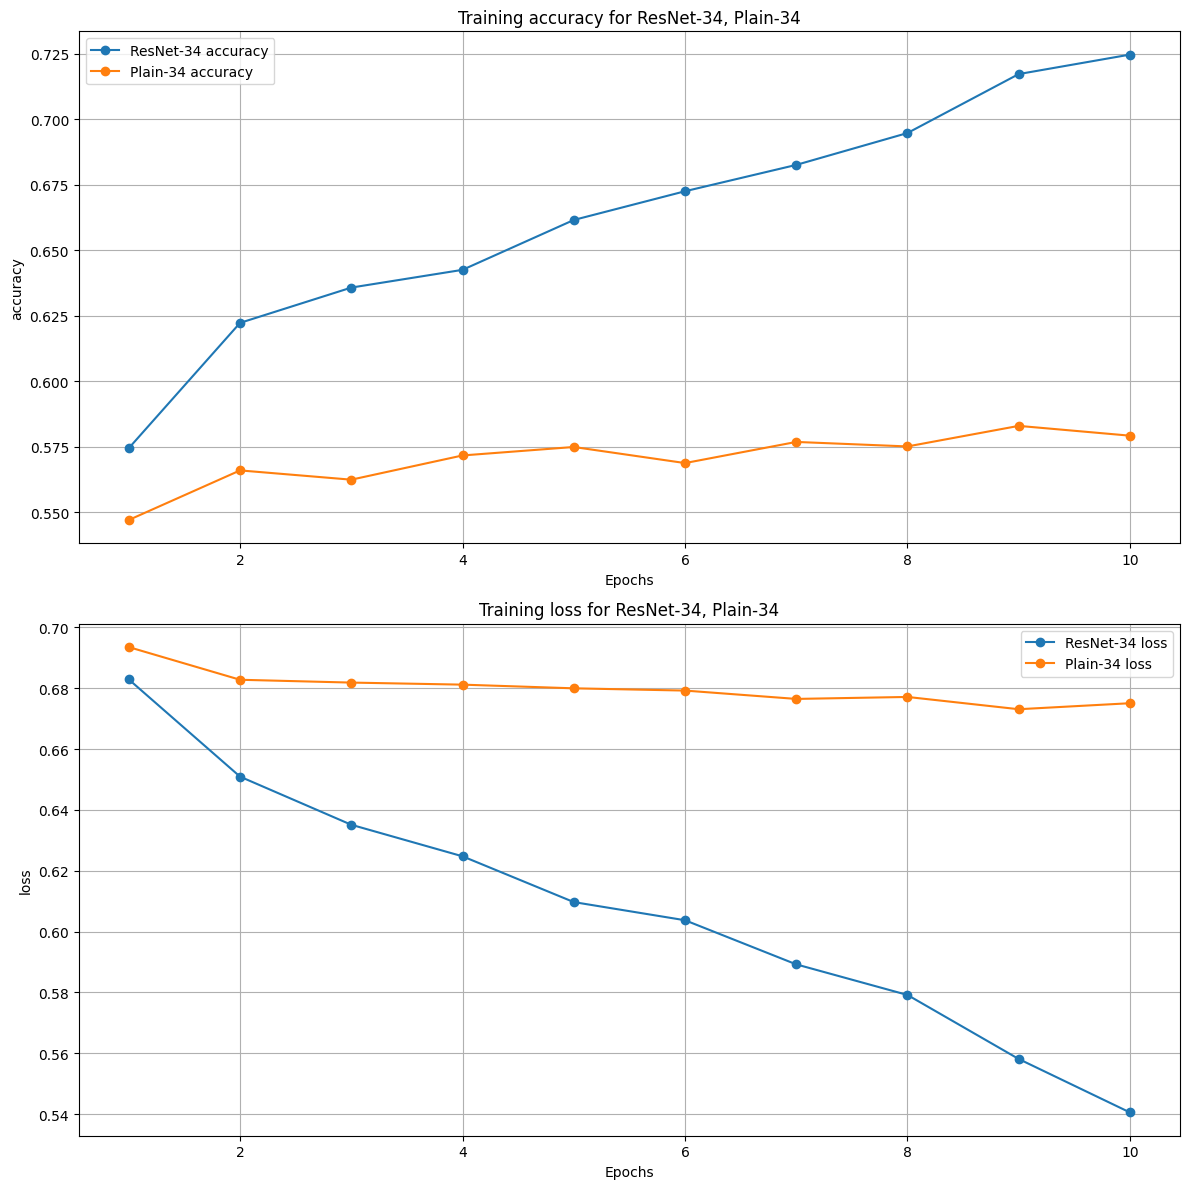

In [74]:
Resnet_Plain_34_hisotries = [history_Resnet_34, history_Plain_34]
Resnet_Plain_34_model_name = ['ResNet-34', 'Plain-34']

plot_training_metrics(Resnet_Plain_34_hisotries, Resnet_Plain_34_model_name, ['accuracy', 'loss'])

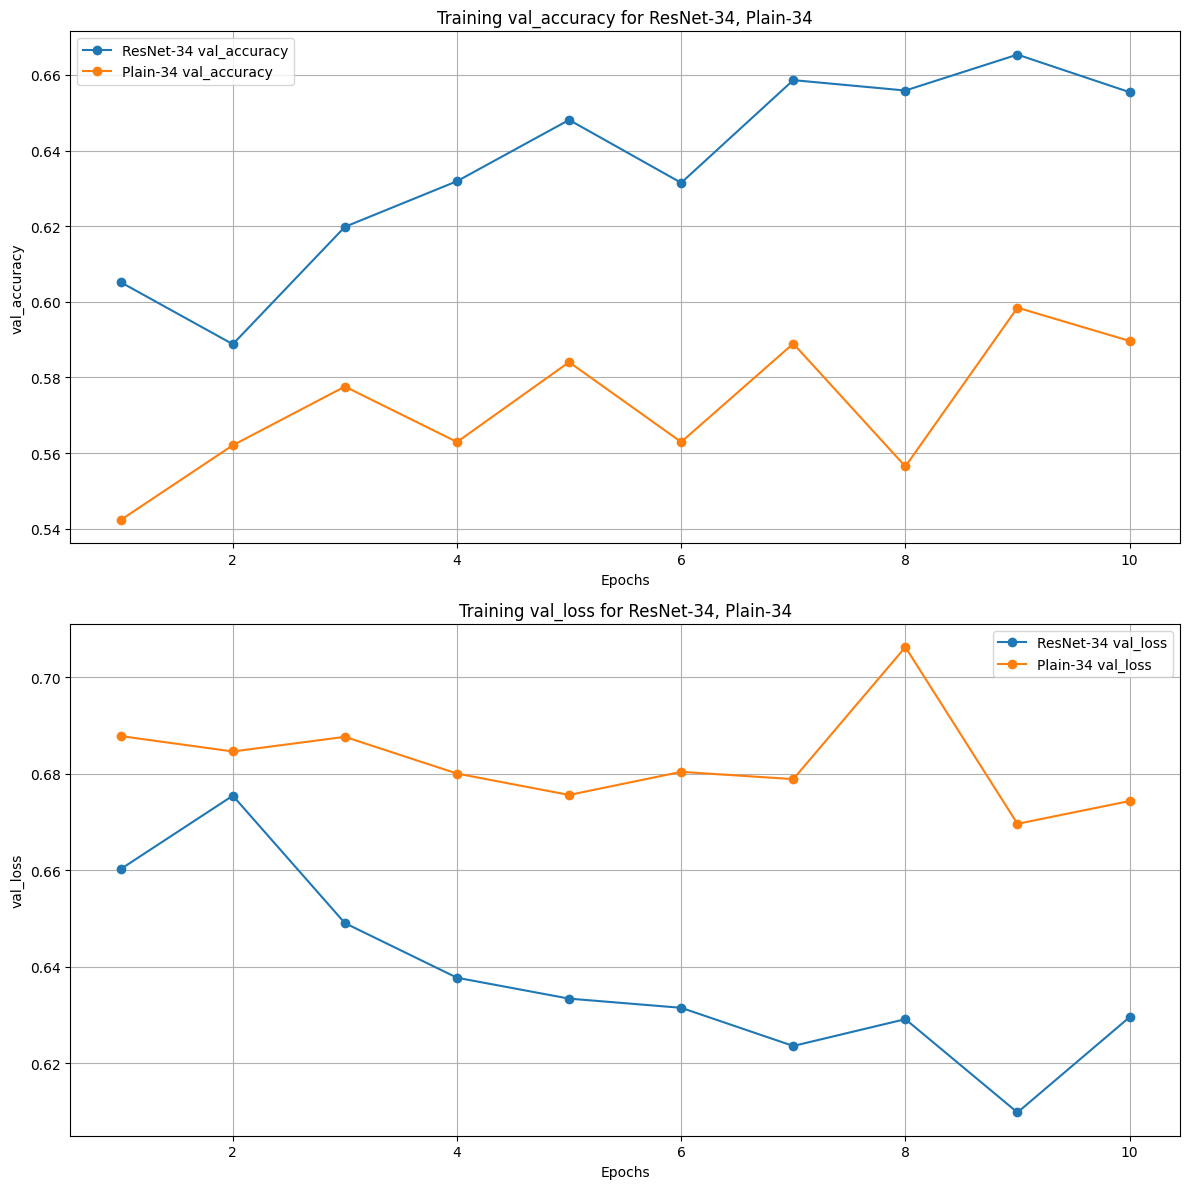

In [75]:
plot_training_metrics(Resnet_Plain_34_hisotries, Resnet_Plain_34_model_name, ['val_accuracy', 'val_loss'])

## ResNet-50, Plain-50의 비교 결과 시각화

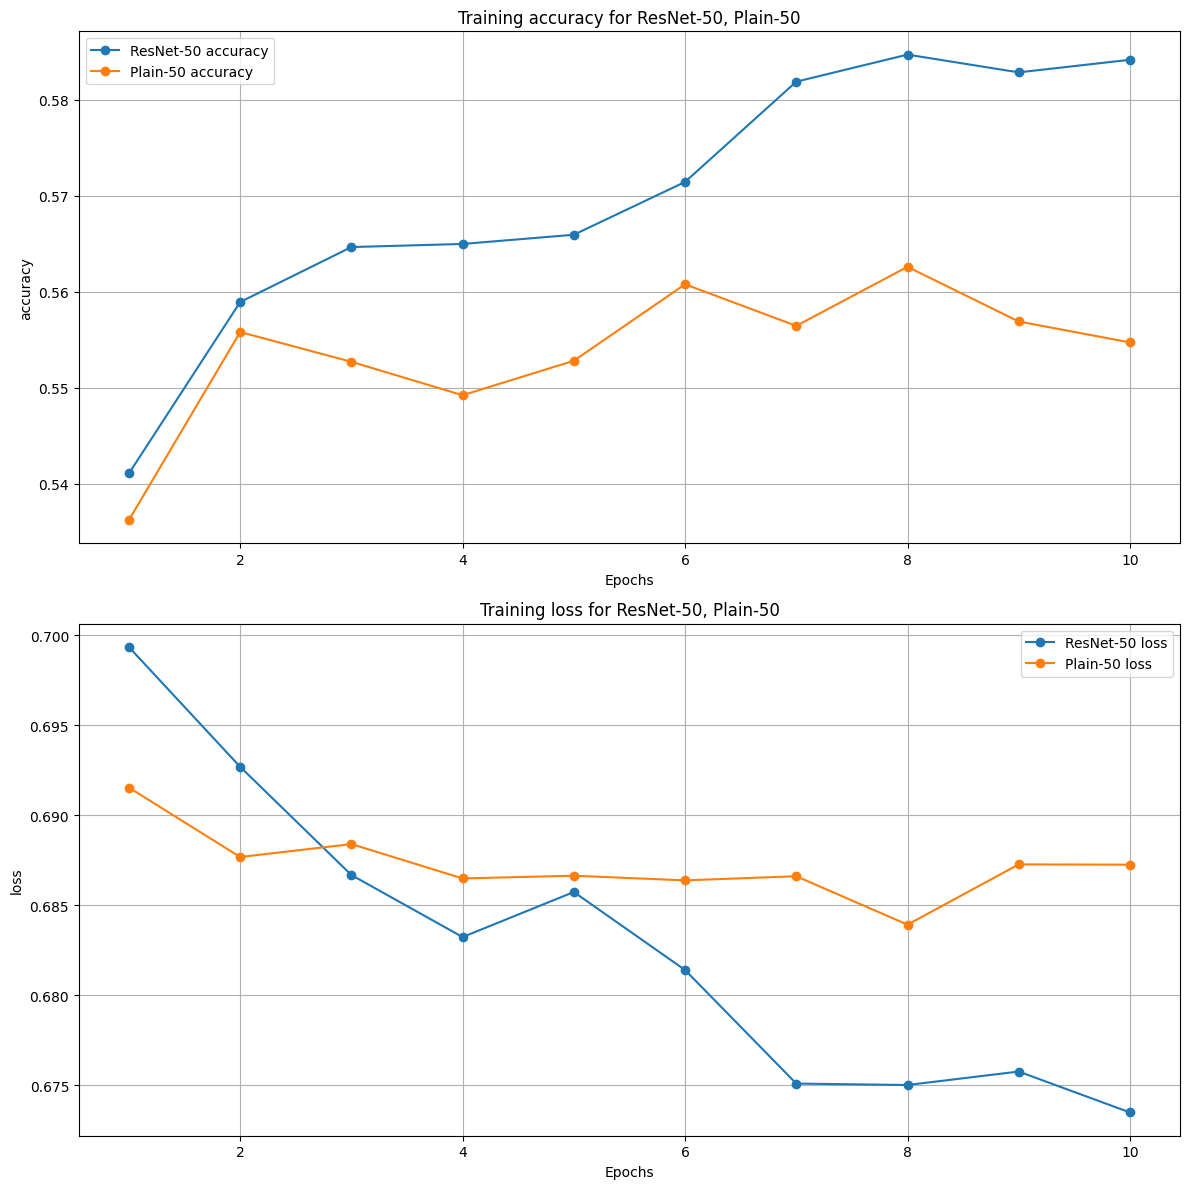

In [76]:
Resnet_Plain_50_hisotries = [history_Resnet_50, history_Plain_50]
Resnet_Plain_50_model_name = ['ResNet-50', 'Plain-50']

plot_training_metrics(Resnet_Plain_50_hisotries, Resnet_Plain_50_model_name, ['accuracy', 'loss'])

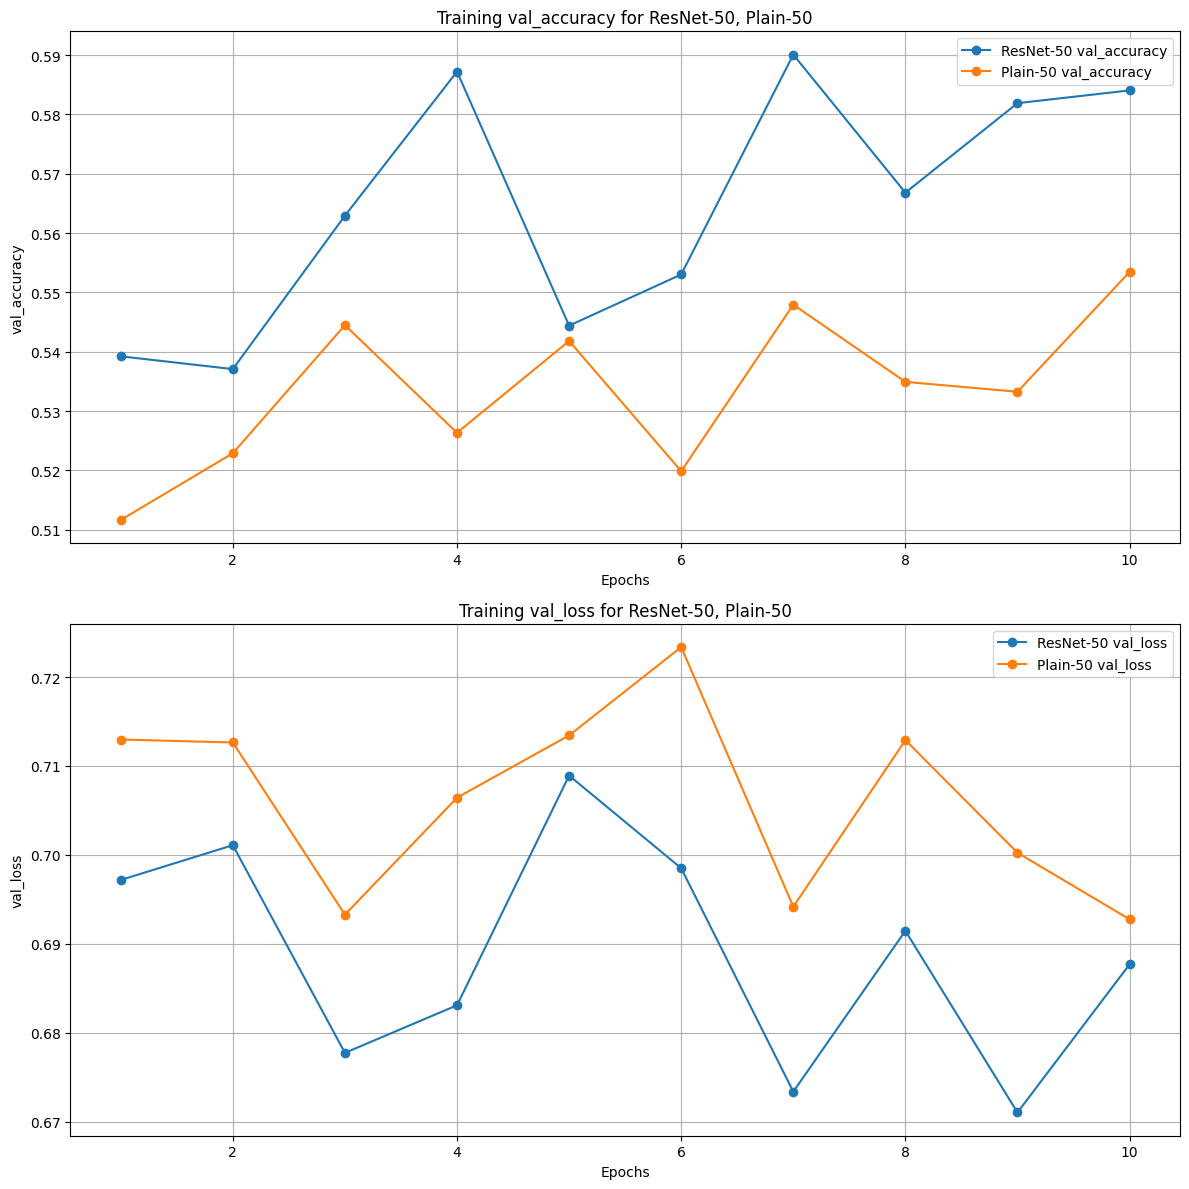

In [77]:
plot_training_metrics(Resnet_Plain_50_hisotries, Resnet_Plain_50_model_name, ['val_accuracy', 'val_loss'])

## 전체 결과 비교 시각화

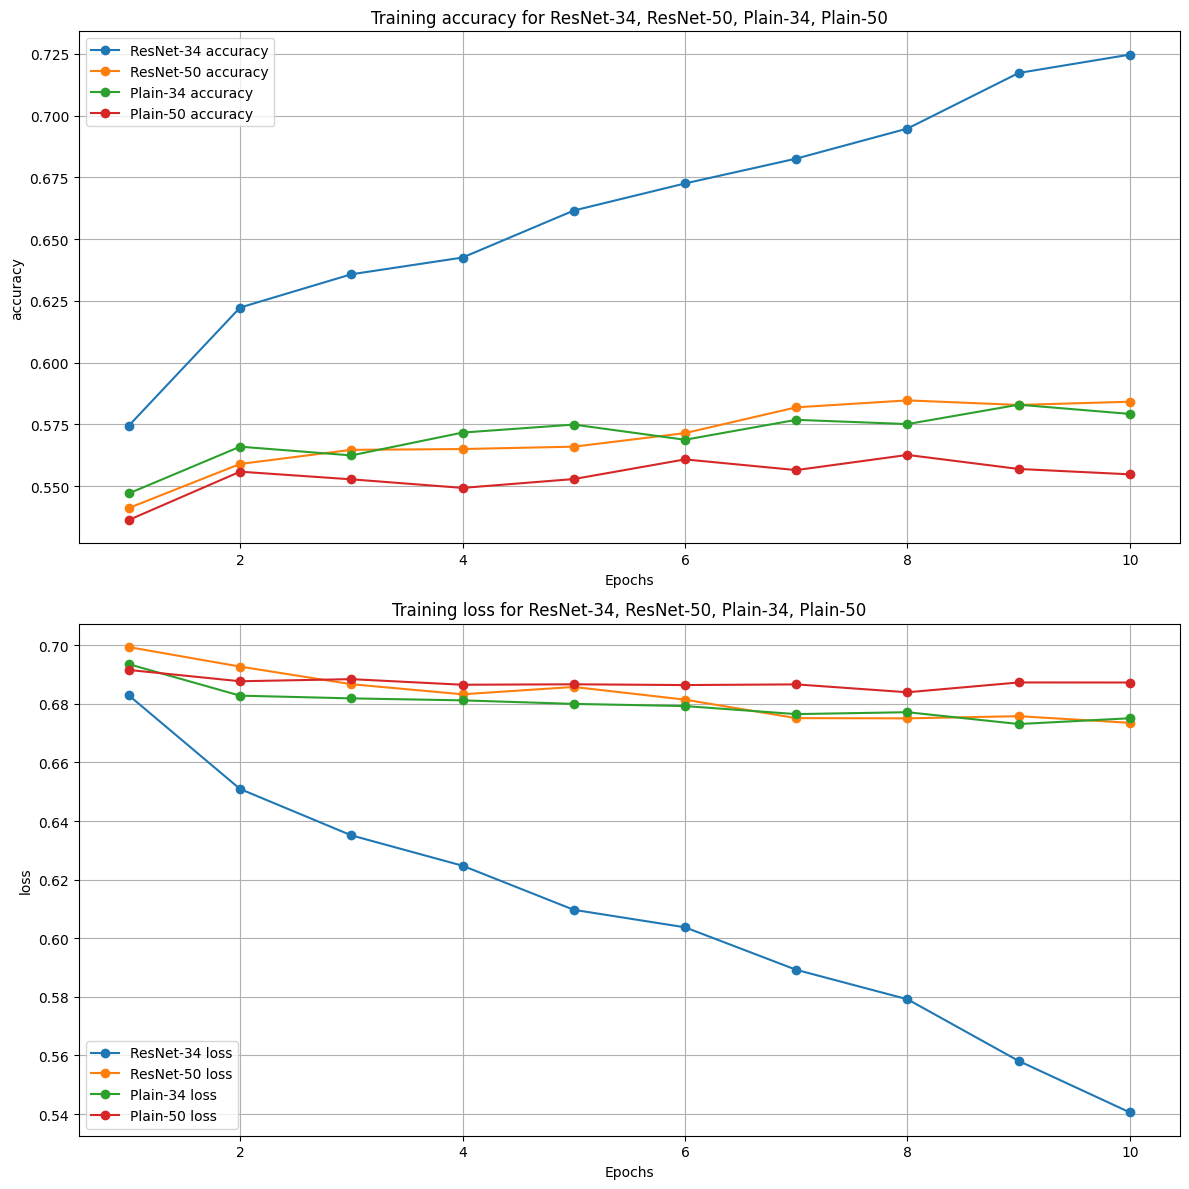

In [78]:
all_hisotries = [history_Resnet_34, history_Resnet_50, history_Plain_34, history_Plain_50]
all_model_name = ['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50']


plot_training_metrics(all_hisotries, all_model_name, ['accuracy', 'loss'])

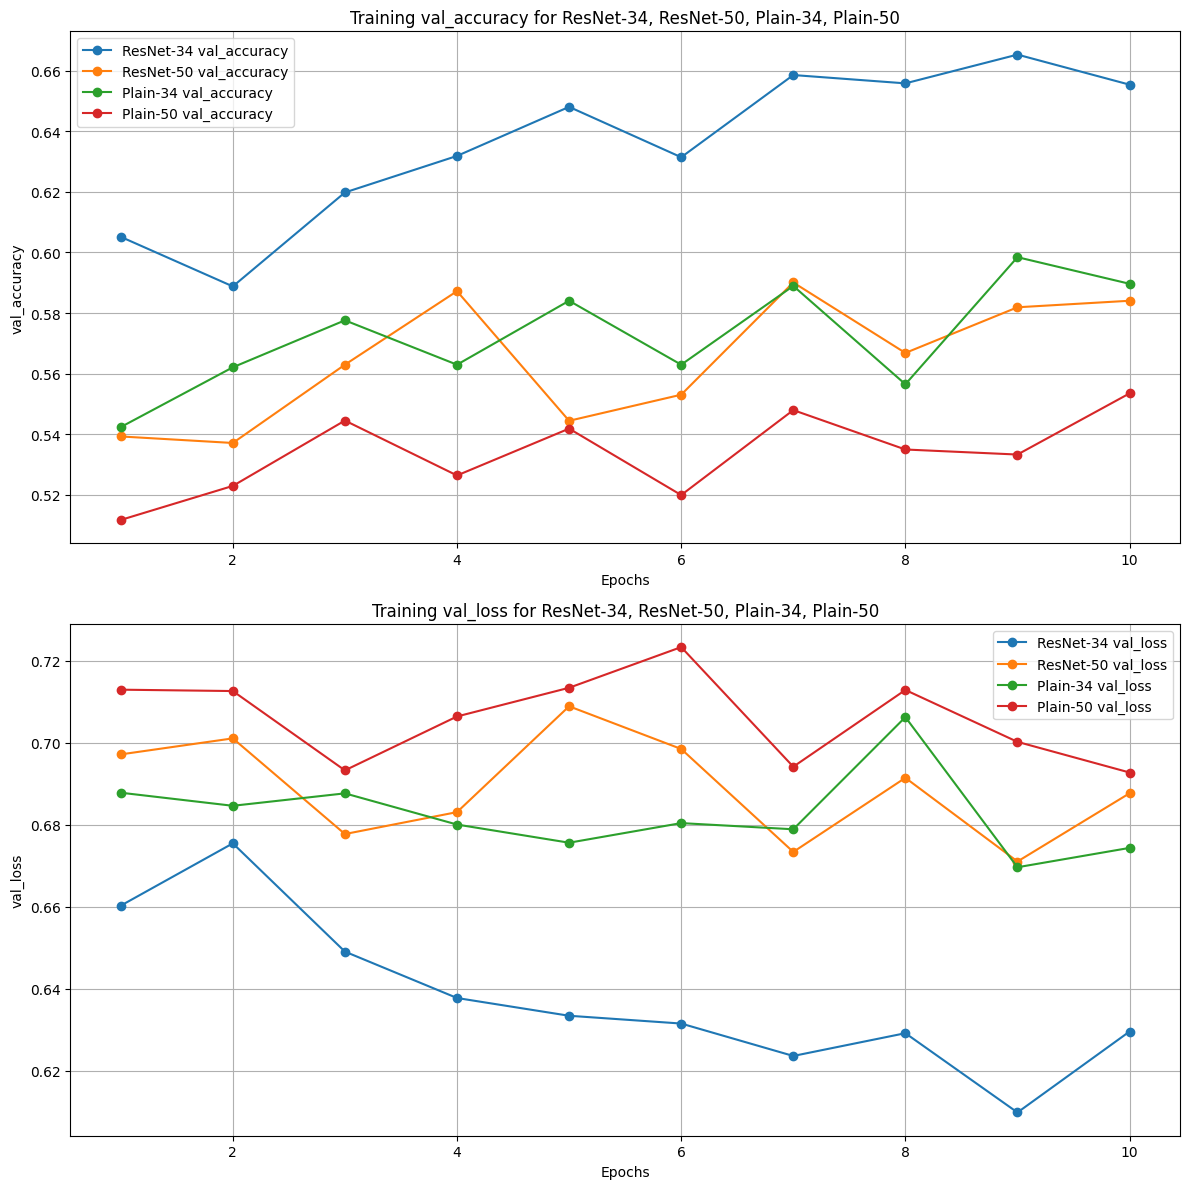

In [79]:
plot_training_metrics(all_hisotries, all_model_name, ['val_accuracy', 'val_loss'])

- ResNet-50은 일반 네트워크하고 성능이 비슷한 결과 ResNet-50은 모델을 잘못 설계한 것 같다.

## 회고
- 모델 설계하는 부분에서 생각보다 복잡하고 어려웠지만 여러 자료를 참고하여 설계하였다.
- ResNet-50의 모델을 설계를 잘못하여 성능이 일반 네트워크와 비슷한 결과가 나와 이 부분은 향후 수정해야겠다.
- 다른 그루분들은 LMS 환경에서 'cats_vs_dogs' 데이터셋 load하는 부분에서 오류가 났지만, 나는 colab으로 진행하여 이부분을 인지하지 못했다. LMS 환경에서 데이터셋을 불러오는 오류를 고쳐보는 과정도 중요할꺼같다.